In [1]:
from scipy import stats
from numpy.random import binomial
from numpy.random import normal

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import t, norm

In [2]:
df = pd.read_csv('data/data_ab.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [5]:
print("Уникальные значения в 'group':", df['group'].unique())
print("Уникальные значения в 'landing_page':", df['landing_page'].unique())
print("Уникальные значения в 'converted':", df['converted'].unique())
df.duplicated('user_id').sum()

Уникальные значения в 'group': ['control' 'treatment']
Уникальные значения в 'landing_page': ['old_page' 'new_page']
Уникальные значения в 'converted': [0 1]


np.int64(3894)

# Проверка замысла A/B теста:
* ## Группа A (control + old_page):
  *  `group` = `control`

  *  `landing_page` = `old_page`

* ## Группа B (treatment + new_page):
  *  `group` = `treatment`

  *  `landing_page` = `new_page`

In [6]:

print("Всего строк:", len(df))
print(df['group'].value_counts())
print(df['landing_page'].value_counts())
cross = pd.crosstab(df['group'], df['landing_page'])
cross

Всего строк: 294478
group
treatment    147276
control      147202
Name: count, dtype: int64
landing_page
old_page    147239
new_page    147239
Name: count, dtype: int64


landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [7]:
control_old = cross.loc['control', 'old_page']
control_new = cross.loc['control', 'new_page']
treatment_old = cross.loc['treatment', 'old_page']
treatment_new = cross.loc['treatment', 'new_page']

print(f"Control + Old: {control_old}")
print(f"Control + New: {control_new}")
print(f"Treatment + Old: {treatment_old}")
print(f"Treatment + New: {treatment_new}")

print(f"Ошибочных кимбинаций: {control_new + treatment_old}, {(control_new + treatment_old)/len(df)*100:.2f}%")

Control + Old: 145274
Control + New: 1928
Treatment + Old: 1965
Treatment + New: 145311
Ошибочных кимбинаций: 3893, 1.32%


Обнаружено 3893 пользователей (1.3%), у которых показанная версия страницы не совпадала с назначенной группой. Данные пользователя с ошибочной комбинацией (control+new_page или treatment+old_page) исключены из анализа, так как нарушают протокол эксперимента и могут искажать итоговый эффект.


In [8]:
df_clean = df[((df['group'] == 'control') & (df['landing_page'] == 'old_page')) | ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))]
print("Пользователи несколько раз совершившие целевое действие:", df_clean.duplicated('user_id').sum())
df_clean = df_clean.drop_duplicates(subset='user_id', keep='first')

Пользователи несколько раз совершившие целевое действие: 1


При подготовке данных A/B-теста критически важно удалять дубликаты пользователей после фильтрации несоответствующих групп. Один пользователь, учтённый дважды, нарушает независимость наблюдений и искажает статистическую значимость результатов, что может привести к некорректным выводам по эффективности тестируемых изменений.

In [9]:
print(f"CONTROL")
print(f"Начало: {df[df['group'] == 'control']['timestamp'].min()}")
print(f"Конец: {df[df['group'] == 'control']['timestamp'].max()}")

print(f"TREATMENT")
print(f"Начало: {df[df['group'] == 'treatment']['timestamp'].min()}")
print(f"Конец: {df[df['group'] == 'treatment']['timestamp'].max()}")

CONTROL
Начало: 2025-01-02 13:42:15.234051
Конец: 2025-01-24 13:41:54.460509
TREATMENT
Начало: 2025-01-02 13:42:05.378582
Конец: 2025-01-24 13:41:44.097174


Тест длился ровно 22 дня с практически одновременным стартом групп (разница 10 секунд). Данные можно считать корректными для сравнения контрольной и тестовой групп.

In [10]:
first_day = df[df['timestamp'].dt.date == pd.to_datetime('2025-01-02').date()]
print(f"Конверсия в первый день: {first_day['converted'].mean():.2%}")

last_day = df[df['timestamp'].dt.date == pd.to_datetime('2025-01-24').date()]
print(f"Конверсия в последний день: {last_day['converted'].mean():.2%}")

other_days = df[~df['timestamp'].dt.date.isin([pd.to_datetime('2025-01-02').date(), pd.to_datetime('2025-01-24').date()])]
print(f"Конверсия в остальные дни: {other_days['converted'].mean():.2%}")

Конверсия в первый день: 12.28%
Конверсия в последний день: 11.94%
Конверсия в остальные дни: 11.96%


Эксперимент стартовал и завершился в середине календарного дня, поэтому первый и последний дни содержат только часть трафика.
Использование таких дней приводит к смещению оценок дневной конверсии и может искажать сравнение групп.
Чтобы обеспечить сопоставимость наблюдений во времени, мы исключили эти частично наблюдаемые дни.

In [11]:
df_filtred = df_clean[(df_clean['timestamp'].dt.date > df_clean['timestamp'].min().date()) & (df_clean['timestamp'].dt.date < df_clean['timestamp'].max().date())]
print(df_filtred['timestamp'].min())
df_filtred['timestamp'].max()

2025-01-03 00:00:04.438127


Timestamp('2025-01-23 23:59:55.572893')

In [12]:
df_filtred['date'] = pd.to_datetime(df_filtred['timestamp'].dt.date)

C:\Users\user\AppData\Local\Temp\ipykernel_1456\1390900365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtred['date'] = pd.to_datetime(df_filtred['timestamp'].dt.date)


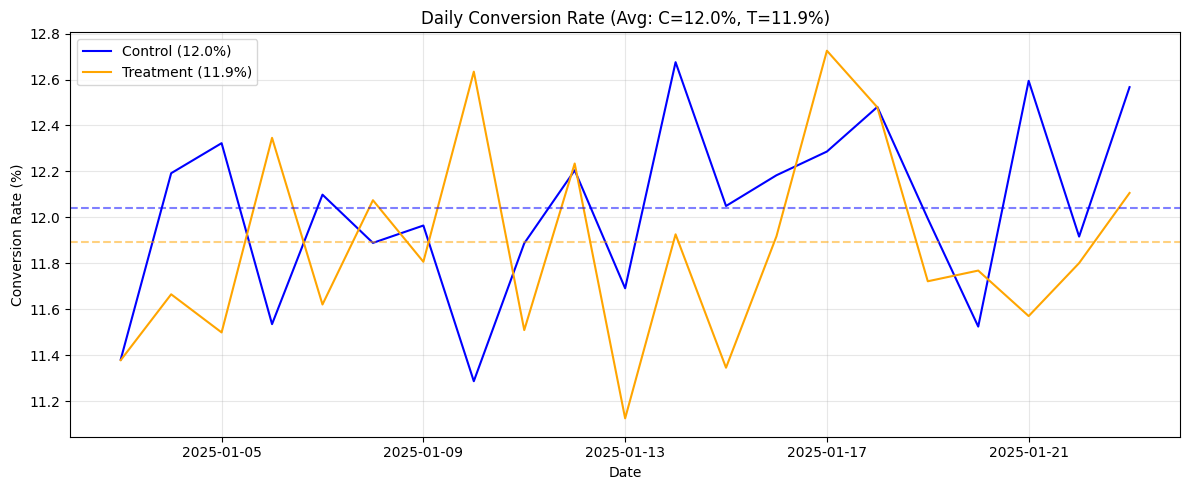

In [13]:
control = df_filtred[df_filtred['group']=='control'].groupby('date')['converted'].mean() * 100
treatment = df_filtred[df_filtred['group']=='treatment'].groupby('date')['converted'].mean() * 100
control_mean = df[df['group']=='control']['converted'].mean() * 100
treatment_mean = df[df['group']=='treatment']['converted'].mean() * 100

plt.figure(figsize=(12, 5))
plt.plot(control.index, control.values, label=f'Control ({control_mean:.1f}%)', color='blue')
plt.plot(treatment.index, treatment.values, label=f'Treatment ({treatment_mean:.1f}%)', color='orange')

plt.axhline(y=control_mean, color='blue', linestyle='--', alpha=0.5)
plt.axhline(y=treatment_mean, color='orange', linestyle='--', alpha=0.5)
plt.title(f'Daily Conversion Rate (Avg: C={control_mean:.1f}%, T={treatment_mean:.1f}%)')
plt.xlabel('Date')
plt.ylabel('Conversion Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

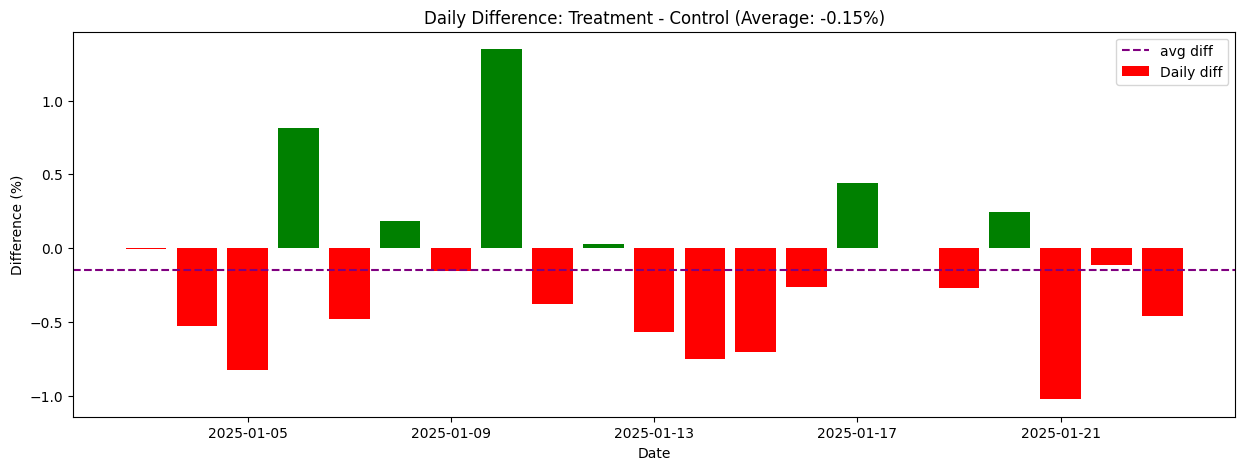

In [20]:
diff = treatment - control
avg_diff = treatment_mean - control_mean
diff


plt.figure(figsize=(15, 5))
colors = ['green' if x > 0 else 'red' for x in diff]
plt.bar(diff.index, diff.values, color=colors, label='Daily diff')
plt.axhline(avg_diff, color='purple', linestyle='--', label='avg diff')
plt.title(f'Daily Difference: Treatment - Control (Average: {avg_diff:+.2f}%)')
plt.xlabel('Date')
plt.ylabel('Difference (%)')
plt.legend()

plt.show() 

Несмотря на локальное расхождение в отдельный день, динамика до и после остаётся синхронной, а средние значения по периоду практически совпадают. Это указывает на отсутствие устойчивого эффекта и на случайный характер отклонения.

Если бы эффект был связан с версией лендинга, мы бы ожидали повторяемости или накопления эффекта во времени. Поскольку расхождение наблюдается только в одном дне и не подтверждается агрегированными метриками и статистическим тестом, мы не интерпретируем его как эффект.

Этот график используется как диагностический инструмент. Окончательный вывод о превосходстве одной из версий делается на основе агрегированного статистического теста по всем пользователям, а не по отдельным дням.

После проверки корректности данных и отсутствия временных искажений, следующим шагом была валидация процедуры эксперимента с помощью A/A теста.

In [38]:
control_df = df[df['group'] == 'control'].copy()

np.random.seed(42)
control_df['fake_group'] = np.random.choice(['A1', 'A2'], size=len(control_df))

print("Размеры групп:")
print(control_df['fake_group'].value_counts())

Размеры групп:
fake_group
A2    73660
A1    73542
Name: count, dtype: int64


In [40]:
conv_A1 = control_df[control_df['fake_group'] == 'A1']['converted'].mean()
conv_A2 = control_df[control_df['fake_group'] == 'A2']['converted'].mean()

print(f"Конверсия A: {conv_A1} ({conv_A1*100:.2f}%)")
print(f"Конверсия B: {conv_A2} ({conv_A2*100:.2f}%)")

Конверсия A: 0.12036659323923744 (12.04%)
Конверсия B: 0.12043171327721966 (12.04%)


In [41]:
from statsmodels.stats.proportion import proportions_ztest

success_A1 = control_df[control_df['fake_group'] == 'A1']['converted'].sum()
success_A2 = control_df[control_df['fake_group'] == 'A2']['converted'].sum()
n_A1 = len(control_df[control_df['fake_group'] == 'A1'])
n_A2 = len(control_df[control_df['fake_group'] == 'A2'])

z_stat, p_value = proportions_ztest([success_A1, success_A2], [n_A1, n_A2])

print(z_stat, p_value)

-0.0383872312551294 0.9693789414616656


A/A тест был проведён на контрольной группе, которая была случайно разделена на две подгруппы.
Полученное p-value оказалось больше 0.05, что означает отсутствие статистически значимых различий.
Это подтверждает корректность рандомизации и применяемого статистического теста.

H0: Конверсия пользователей в контрольной и тестовой группах одинакова

H1: Конверсия пользователей в контрольной и тестовой группах различается

In [42]:
success_A = df_filtred[df_filtred['group'] == 'control']['converted'].sum()
success_B = df_filtred[df_filtred['group'] == 'treatment']['converted'].sum()
n_A = len(df_filtred[df_filtred['group'] == 'treatment'])
n_B = len(df_filtred[df_filtred['group'] == 'treatment'])

z_stat, p_value = proportions_ztest([success_A, success_B], [n_A, n_B])

print(z_stat, p_value)

1.2465088620998173 0.21257763774453886


По результатам двухвыборочного z-теста p-value > 0.05, поэтому нулевая гипотеза не отвергается. Статистически значимых различий в конверсии между версиями лендинга не обнаружено.

In [48]:
control = df_filtred[df_filtred['group']=='control']['converted'].values
treatment = df_filtred[df_filtred['group']=='treatment']['converted'].values
diffs = []
for _ in range(10000):
    sample_control = np.random.choice(control, size=len(control), replace=True)
    sample_treatment = np.random.choice(treatment, size=len(treatment), replace=True)
    diffs.append(sample_treatment.mean() - sample_control.mean())
diffs = np.array(diffs)
print("Mean diffs:", diffs.mean())
print("2.5 percentile:", np.percentile(diffs, 2.5))
print("97.5 percentile:", np.percentile(diffs, 97.5))

Mean diffs: -0.0016458792860513981
2.5 percentile: -0.004035166209704035
97.5 percentile: 0.0007234195998672966


В бутстрап-анализе средняя разница конверсий составила −0.16%. При этом основной диапазон значений находится между −0.40% и +0.07%, включая нулевую разницу. Это указывает на отсутствие устойчивого эффекта и подтверждает результат A/B теста.